# Getting Started | U-Net with OpenPack Dataset (IMU)

## [0] Inital Setup

### 0-1: Download Code and Install `openpack-torch` 
NOTE: You can also install `openpack-torch` from PyPI with `pip install openpack-torch`.

In [ ]:
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

In [1]:
! cd /content/openpack-torch/ && pip install .

Defaulting to user installation because normal site-packages is not writeable
Processing /home/bob/openpack-torch
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openpack-torch: filename=openpack_torch-0.2.0-py3-none-any.whl size=18921 sha256=b226d3d2e0c450e1ae9e054d2f747f55358999c8e16f2631ef862697543db04d
  Stored in directory: /home/bob/.cache/pip/wheels/9e/aa/9d/cad8d0b1efb54b3f83948f6641caa69c9d6dc2e97c596315e2
Successfully built openpack-torch
  Attempting uninstall: openpack-torch
    Found existing installation: openpack-torch 0.2.0
    Uninstalling openpack-torch-0.2.0:
      Successfully uninstalled openpack-torch-0.2.0


### 0-2: Download Dataset to  `/content/data`
- Souce (IMU data of U0102): TBA

In [2]:
! mkdir -p /content/data/datasets/
! optk-download -d /content/data/datasets -v v0.2.0 -s atr-qags,openpack-operations

INFO:openpack_toolkit.bin.download:Donwload OpenPack dataset from zenodo.
INFO:openpack_toolkit.bin.download: - dataset_dir : /content/data/datasets
INFO:openpack_toolkit.bin.download: - version     : v0.2.0
INFO:openpack_toolkit.bin.download: - streams     : ['atr-qags', 'openpack-operations']
INFO:openpack_toolkit.download._helpers:== [0/2] atr-qags ==
INFO:openpack_toolkit.download._helpers:[0/4] U0102
INFO:openpack_toolkit.download._helpers:[1/4] U0103
INFO:openpack_toolkit.download._helpers:[2/4] U0105
INFO:openpack_toolkit.download._helpers:[3/4] U0106
INFO:openpack_toolkit.download._helpers:== [1/2] openpack-operations ==
INFO:openpack_toolkit.download._helpers:[0/4] U0102
INFO:openpack_toolkit.download._helpers:[1/4] U0103
INFO:openpack_toolkit.download._helpers:[2/4] U0105
INFO:openpack_toolkit.download._helpers:[3/4] U0106


In [3]:
! tree /content/data/datasets/openpack/v0.2.0

/content/data/datasets/openpack/v0.2.0
├── U0102
│   ├── annotation
│   │   └── openpack-operations
│   │       ├── S0100.csv
│   │       ├── S0200.csv
│   │       ├── S0300.csv
│   │       ├── S0400.csv
│   │       └── S0500.csv
│   ├── atr
│   │   ├── atr01
│   │   │   ├── S0100.csv
│   │   │   ├── S0200.csv
│   │   │   ├── S0300.csv
│   │   │   ├── S0400.csv
│   │   │   └── S0500.csv
│   │   ├── atr02
│   │   │   ├── S0100.csv
│   │   │   ├── S0200.csv
│   │   │   ├── S0300.csv
│   │   │   ├── S0400.csv
│   │   │   └── S0500.csv
│   │   ├── atr03
│   │   │   ├── S0100.csv
│   │   │   ├── S0200.csv
│   │   │   ├── S0300.csv
│   │   │   ├── S0400.csv
│   │   │   └── S0500.csv
│   │   └── atr04
│   │       ├── S0100.csv
│   │       ├── S0200.csv
│   │       ├── S0300.csv
│   │       ├── S0400.csv
│   │       └── S0500.csv
│   └── kinect
│       └── 2d-kpt
│           └── mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2
│               ├── U0102
│               │   └── single
│   

### 0-3: Import Modules

In [4]:
import os
import shutil
import logging
from pathlib import Path
from typing import Dict

import hydra
import numpy as np
import openpack_toolkit as optk
import openpack_torch as optorch
import pandas as pd
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from hydra import initialize_config_dir, compose
from omegaconf import DictConfig, OmegaConf
from openpack_toolkit import OPENPACK_OPERATIONS
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

sns.set("notebook", "whitegrid")

### 0-4: Setup Logger

In [5]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2022-06-28 17:33:45 | INFO | __main__ | info
2022-06-28 17:33:45 | WARNING | __main__ | warning


## [1] Load Config File

Register OpenPaack official configs to hydra.
Fore more information of official configs, please refer to [openpack_toolkit/configs](https://github.com/open-pack/openpack-toolkit/tree/main/openpack_toolkit/configs).

In [6]:
optorch.configs.register_configs()

Load and update some parameters of hydra's configuration files. You can overrrides default parameters by adding entries to overrides array.

In [7]:
config_dir = Path("/content/openpack-torch/examples/unet/configs")
overrides = [
    "mode=train",
    "issue=I01-EXP1-V1-nb",
    "debug=false",
    "datarootdir=/content/data",
    "hydra/job_logging=custom",
    "hydra/hydra_logging=disabled"
]

with initialize_config_dir(version_base=None, config_dir=str(config_dir)):
    cfg = compose(
        config_name="operation-segmentation.yaml",
        overrides=overrides,
    )

In [8]:
print(OmegaConf.to_yaml(cfg))

dataset:
  annotation:
    name: openpack-operations
    version: v3.0.0
    path:
      dir: ${path.openpack.rootdir}/${user.name}/annotation/${..name}
      fname: ${session}.csv
    file_format: null
    classes:
      classes:
      - id: 100
        name: Picking
        is_ignore: false
      - id: 200
        name: RelocateItemLabel
        is_ignore: false
      - id: 300
        name: AssembleBox
        is_ignore: false
      - id: 400
        name: InsertItems
        is_ignore: false
      - id: 500
        name: CloseBox
        is_ignore: false
      - id: 600
        name: AttachBoxLabel
        is_ignore: false
      - id: 700
        name: ScanLabel
        is_ignore: false
      - id: 800
        name: AttachShippingLabel
        is_ignore: false
      - id: 900
        name: PutOnRack
        is_ignore: false
      - id: 1000
        name: Fill-outOrder
        is_ignore: false
      - id: 8100
        name: 'Null'
        is_ignore: true
  stream:
    schema: ImuCon

## [2] Define Utilities (Pytorch Lightning Modules)

### 2-1: DataModule

Override `optorch.data.OpenPackBaseDataModule` to use IMU dataset.

In [9]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 2-2: Lightning Module

In the `init_criterion()` method, you can register your custom loss function.
But make sure that ignore classes are excluded from evaluation process.
For `torch.nn.CrossEntropyLoss`, you can use `ignore_class` parameter.

In [10]:
class UNetLM(optorch.lightning.BaseLightningModule):

    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        dstream_conf = self.cfg.dataset.stream
        in_ch = len(dstream_conf.devices) * 3

        model = optorch.models.imu.UNet(
            in_ch,
            len(OPENPACK_OPERATIONS),
            depth=cfg.model.depth,
        )
        return model
    
    
    def init_criterion(self, cfg: DictConfig):
        ignore_cls = [(i, c) for i, c in enumerate(cfg.dataset.annotation.classes.classes) if c.is_ignore]
        
        criterion = torch.nn.CrossEntropyLoss(
            ignore_index=ignore_cls[-1][0]
        )
        return criterion

    def training_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        return outputs


## [3] Train U-Net

### 3-1: Initialize U-Net Model and DataLoader.

In [11]:
device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg)
plmodel = UNetLM(cfg).to(dtype=torch.float, device=device)

2022-06-28 17:33:46 | INFO | torch.distributed.nn.jit.instantiator | Created a temporary directory at /tmp/tmp7me7flg3
2022-06-28 17:33:46 | INFO | torch.distributed.nn.jit.instantiator | Writing /tmp/tmp7me7flg3/_remote_module_non_sriptable.py


In [12]:
plmodel

UNetLM(
  (net): UNet(
    (inc): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (encoder): UNetEncoder(
      (conv_blocks): ModuleList(
        (0): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
          )
          (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        )
        (1): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3,

### 3-2: Initialize Trainer

In [13]:
num_epoch = cfg.train.debug.epochs if cfg.debug else cfg.train.epochs
# num_epoch = 50 # NOTE: Set epochs manually for debugging

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=0,
    save_last=True,
    monitor=None,
)

trainer = pl.Trainer(
    gpus=[0],
    max_epochs=num_epoch,
    logger=False,  # disable logging module
    default_root_dir=logdir,
    enable_progress_bar=False,  # disable progress bar
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)
logger.debug(f"logdir = {logdir}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3-3: Start training!

In [14]:
logger.info(f"Start training for {num_epoch} epochs.")
trainer.fit(plmodel, datamodule)
logger.info("Finish training!")

2022-06-28 17:33:48 | INFO | __main__ | Start training for 100 epochs.
2022-06-28 17:33:50 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 17:33:51 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 17:33:51 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 17:33:51 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False)
2022-06-28 17:33:51 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7f88a3e67910>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7f88a3e11340>}
2022-06-28 17:33:51 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-06-28 17:33:51 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------

### 3-4: Plot Training Curve

Training logs are stored in `plmodel.log` (dict). Let's visualize training curves for training and validation set.

In [15]:
df = pd.concat([
    pd.DataFrame(plmodel.log["train"]),
    pd.DataFrame(plmodel.log["val"]),
],axis=1,)
df.index.name = "epoch"

In [16]:
df.head()

,train/loss,train/acc,val/loss,val/acc
epoch,,,,
0,2.454549,0.093660,2.406149,0.169969
1,2.387878,0.133143,2.397081,0.079403
2,2.328653,0.180514,2.388228,0.081888
3,2.280589,0.216817,2.363564,0.146761
4,2.236243,0.245523,2.318975,0.198257


Training Log

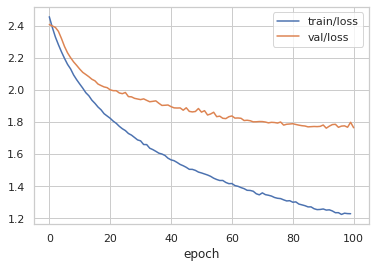

In [17]:
df[["train/loss", "val/loss"]].plot()
plt.show()

Test Log

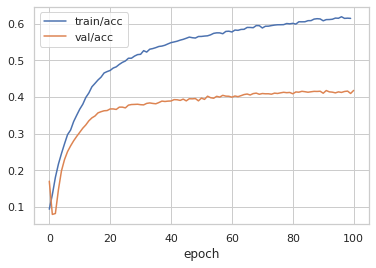

In [18]:
df[["train/acc", "val/acc"]].plot()
plt.show()

## [4] Test

Evaluation function is defined in `optk.codalab.eval_operation_segmentation_wrapper()`. This function takes dict as the 1st argument and prediction (`y`), groundtruth (`t_idx`; activity class index) and corresponding unixtime (`unixtime`) must be included in the dict object. Each sequence should be stored in the different entries with a key `{user}-{session}` (e.g., `U0107-S0100`). For the detail, please refere to the following examples.

```python
outputs = {
    "U0107-S0100": {
        "t_idx": [0, 0, ...], # groundtruth (class index)
        "y": [
            [
                [0., 0., ...],
                [0., 0., ...],
                [1., 1., ...],
            ],
        ], # prediction. shape=(B,N_CLASSES,T), dtype=float
        "unixtiume": [634885794000, 1634885794200, ...], # unixtime
    },
    "U0107-S0200": {
        "t_idx": [...], 
        "y": [...],
        "unixtiume": [...],
    },
    ...
}
```

### 4-1: Get prediction results for each sequences and build result dict.

In [19]:
datamodule.setup("test")
dataloaders = datamodule.test_dataloader()
split = cfg.dataset.split.test


outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on U{user}-S{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"U{user}-S{session}"] = {
        "t_idx": plmodel.test_results.get("t"),
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2022-06-28 17:38:18 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 17:38:18 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 17:38:18 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 17:38:18 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-06-28 17:38:18 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-06-28 17:38:18 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f88a4223f10>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f89b5bcd2b0>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f89b5bf82e0>}
2022-06-28 17:38:18 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-06-28 17:38:18 | INFO | __main__ | test on UU0106-SS0100
2022-06-28 17:38:19 | WARNING | openpack_torch.data.datasets | No preprocessing 

### 4-2: Evaluate

In [20]:
# compute performance summary
df_summary = eval_operation_segmentation_wrapper(
    outputs, OPENPACK_OPERATIONS,
)

2022-06-28 17:38:22 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | unsupported user ID: UU0106, skip cropping this sequence.
2022-06-28 17:38:22 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | unsupported user ID: UU0106, skip cropping this sequence.
2022-06-28 17:38:22 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | unsupported user ID: UU0106, skip cropping this sequence.
2022-06-28 17:38:22 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | unsupported user ID: UU0106, skip cropping this sequence.
2022-06-28 17:38:22 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | unsupported user ID: UU0106, skip cropping this sequence.
2022-06-28 17:38:22 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | unsupported user ID: UU0106, skip cropping this sequence.


In [21]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
36,avg/macro,-1,0.366805,0.364654,0.345888,None,all
37,avg/weighted,-1,0.388728,0.391101,0.371942,None,all
38,Picking,100,0.293587,0.519504,0.375160,564,all
39,RelocateItemLabel,200,0.418445,0.586538,0.488434,936,all
40,AssembleBox,300,0.479452,0.303176,0.371462,1039,all
41,InsertItems,400,0.276144,0.342799,0.305882,493,all
42,CloseBox,500,0.370253,0.355083,0.362510,659,all
43,AttachBoxLabel,600,0.111111,0.003021,0.005882,331,all
44,ScanLabel,700,0.472924,0.578792,0.520530,679,all
45,AttachShippingLabel,800,0.385580,0.265659,0.314578,463,all


## [5] Submission

`optk.codalab.construct_submission_dict()` can be used to make submission files to codalab.
The parameter is almost the same as `optk.codalab.eval_operation_segmentation_wrapper()` (used for evaluation), but groundtruth filed (`t_idx`) is exclided.

### 5-1: Get prediction for test data.

NOTE: Data for submission is not available in OpenPack(v0.2.0).  Therefore use test set for debugging purpose.

In [22]:
# datamodule.setup("submission")
# dataloaders = datamodule.submission_dataloader()
# split = cfg.dataset.split.submission

# NOTE: data for submission is not available in OpenPack(v0.2.0).  Therefore use test set for debugging.
datamodule.setup("test")
dataloaders = datamodule.test_dataloader()
split = cfg.dataset.split.test 

outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2022-06-28 17:38:22 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 17:38:22 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 17:38:22 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 17:38:22 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-06-28 17:38:22 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-06-28 17:38:22 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f89bbfd6580>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f89b5c87700>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f88a42d8ee0>}
2022-06-28 17:38:22 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-06-28 17:38:22 | INFO | __main__ | test on U0106-S0100
2022-06-28 17:38:23 | WARNING | openpack_torch.data.datasets | No preprocessing is

### 5-2: Make submission zip file

In the `construct_submission_dict()`, following processing will be done.

- Convert a predcition tesor `y` (3D array of logits) into a 2d matrix of predicted class ids.
- Resample sequence into 1 Hz.
- Exclude the segments that is out of range for the evaluation protocol (i.e., unlabeled or null segments).

In the `make_submission_zipfile()`, following processing will be done.

- extract `prediction` and `unixtime` field 
- generate `submission.json` and `submission.zip` to `output_dir`.

In [23]:
output_dir = Path(".")

submission_dict = construct_submission_dict(
    outputs, OPENPACK_OPERATIONS)
make_submission_zipfile(submission_dict, output_dir)

2022-06-28 17:38:25 | INFO | openpack_toolkit.codalab.operation_segmentation.utils | write submission.json to submission.json
2022-06-28 17:38:25 | INFO | openpack_toolkit.codalab.operation_segmentation.utils | write submission.zip to submission.zip


### 5-3: Submit to codalab and get results!

Now, you got a submission zip file (`./submission.zip`).
Let's upload it in the competition site (codalab) and get your score!